In [53]:
import pandas as pd
import re
from Bio import SeqIO, AlignIO, Seq
import numpy as np
from collections import Counter
from helper import *
import python_cipres.client as CipresClient

### Extract fasta sequences for the autotrophic rubiscos
Before running this code we need to generate a file called `autotrophic_rubisco_70p.csv` by selecting in ITOL clades that belong to Rubisco types 1,2,2/3,3a,3c,3-like,3b and IV. We replaced sapces in the sequence ID to `_` to match the sequence ID in the fasta files. We take only sequences which are not type IV or type III-b as autotrophic.

In [4]:
uclust_data = pd.read_csv('../output/01_70p_tree/uclust_all_0.7.csv')
uclust_data = uclust_data[uclust_data['Type'] !='S']
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data['cut Target'] = uclust_data.Target.apply(lambda x: x.split(' ')[0])
#auto_id = [x.replace('\n','') for x in open('../output/01_70p_tree/autotrophic_rubisco_70p.txt').readlines() if x != '\n']
rubisco_types = pd.read_csv('../output/01_70p_tree/rubisco_types_70p.csv')
autotrophic_70p = rubisco_types[~rubisco_types['type'].isin(['IV','IIIb'])]
auto_rubisco = uclust_data.merge(autotrophic_70p, left_on='cut Target', right_on='ID')
autotrophic_rubisco  = auto_rubisco['Query'].values

auto_seq = []
for record in SeqIO.parse('../output/00_100p_tree/uclust_all_1.faa', "fasta"):
    if record.description in autotrophic_rubisco:
        auto_seq.append(record)
!mkdir -p ../output/02_80p_autotrophic_rubisco_tree
with open(r"../output/02_80p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa", "w") as output_handle:
    SeqIO.write(auto_seq, output_handle, "fasta")

In [5]:
auto_rubisco.to_csv('../output/02_80p_autotrophic_rubisco_tree/uclust_all_0.7_with_type.csv')
auto_rubisco.groupby('type')['Query'].nunique()

type
I           36258
II            326
II/III         51
III-like       99
IIIa           95
IIIc           35
unknown        23
Name: Query, dtype: int64

### Cluster sequences using uclust

In [6]:
!../bin/usearch11.0.667_i86linux32 -cluster_fast ../output/02_80p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa -id 0.8 -uc ../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.uc

usearch v11.0.667_i86linux32, 4.0Gb RAM (16.3Gb total), 8 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: yinonmoise.baron@weizmann.ac.il

00:00 64Mb    100.0% Reading ../output/02_80p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa
00:00 102Mb   100.0% DF
00:00 102Mb  36887 seqs, 36887 uniques, 36887 singletons (100.0%)
00:00 102Mb  Min size 1, median 1, max 1, avg 1.00
00:00 108Mb   100.0% DB
00:02 163Mb   100.0% 325 clusters, max size 7716, avg 113.5
                                                           
      Seqs  36887 (36.9k)
  Clusters  325
  Max size  7716
  Avg size  113.5
  Min size  1
Singletons  169, 0.5% of seqs, 52.0% of clusters
   Max mem  163Mb
      Time  2.00s
Throughput  18.4k seqs/sec.



### Take only cluster fasta files and create csv file

In [7]:
parse_uclust(infile='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.uc',
             fasta='../output/02_80p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa',
             outfasta='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa',
             outfile='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv'
            )

In [8]:
auto_rub_80p = pd.read_csv('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv')
auto_rub_80p = auto_rub_80p[auto_rub_80p['Type'] !='S']
auto_rub_80p.loc[auto_rub_80p['Target'] == '*','Target'] = auto_rub_80p.loc[auto_rub_80p['Target'] == '*','Query']

auto_rub80 = auto_rubisco.merge(auto_rub_80p,left_on='Query',right_on='Query')
auto_rub80.to_csv('../output/02_80p_autotrophic_rubisco_tree/uclust_all_0.8_with_type.csv')
auto_rub80.groupby('type')['Target_y'].nunique()

type
I           149
II           24
II/III       16
III-like     38
IIIa         53
IIIc         25
unknown      20
Name: Target_y, dtype: int64

## Create multiple sequence alignment

In [9]:
!../bin/mafft-linux64/mafft.bat ../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa > ../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.aln

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  301 / 325
done.

Constructing a UPGMA tree (efffree=0) ... 
  320 / 325
done.

Progressive alignment 1/2... 
STEP    69 / 324 
Reallocating..done. *alloclen = 2390
STEP   307 / 324  h
Reallocating..done. *alloclen = 3797
STEP   324 / 324  h
done.

Making a distance matrix from msa.. 
  300 / 325
done.

Constructing a UPGMA tree (efffree=1) ... 
  320 / 325
done.

Progressive alignment 2/2... 
STEP   221 / 324  h
Reallocating..done. *alloclen = 2423
STEP   313 / 324  h
Reallocating..done. *alloclen = 4062
STEP   324 / 324  h
done.

disttbfast (aa) Version 7.427
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'm

## Clean MSA to contain only positions with more than 5% coverage (based on Jaffe et al. 2018)

In [10]:
clean_aln(infile='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.aln',
          outfile='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8_trimmed.aln')

In [193]:
aln = AlignIO.read('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8_trimmed.aln',format='fasta')
seq = SeqIO.parse('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa',format='fasta')
x3 = []
seqs = []

x4= [len(str(x.seq).replace('-',''))/len(y.seq) for x,y in zip(aln,seq)]

#for i in range(len(aln)):
#    x3.append(np.mean([len(x) for x in re.compile("(-+-)*").findall(str(aln[i,:].seq))]))
#[seqs.append(x) for x,y in zip(aln,x3) if y <= np.percentile(x3,95)]
    #if Counter(aln[i,:])['-']/len(aln[i,:])<0.55:
#        seqs.append(aln[i])

#[seqs.append[aln[i]] for i in range(len(aln)) if ]
seqs = [x for x,y in zip(aln,x4) if y>=np.percentile(x4,10)]
with open('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8_trimmed_no_outliers.aln', "w") as output_handle:
        SeqIO.write(seqs, output_handle, "fasta")


#d = [x for x in aln if x.id == 'gi|1491020527|gb|RLF31686.1|'][0]
#re.compile("(-+-)*").findall(str(d.seq))


In [206]:
from ete3 import Tree
r = Tree('../output/02_80p_autotrophic_rubisco_tree/RaxML_old/RAxML_bipartitions.result')
treelen = [x.dist for x in r.get_leaves()]

#pd.Series().plot.hist(bins=20)
outliers = [x.name for x in r.get_leaves() if x.dist >=np.percentile(treelen,95)]
outliers

['gi|1247451339|gb|PCJ09133.1|',
 'gi|1572539947|emb|VDD88979.1|',
 'gi|1491131059|gb|RLG20628.1|',
 'gi|1142664386|gb|ONM23708.1|',
 'gi|922401683|ref|XP_013467978.1|',
 'gi|1271096588|gb|PHT89599.1|',
 'gi|1271174125|gb|PHT97483.1|',
 'gi|1271198659|gb|PHU15862.1|',
 'gi|976902695|gb|KVH90633.1|',
 'TARA_070.SAMEA2621075.5.0.22-0.45_634524_4',
 'TARA_064.SAMEA2620815.1000.0.22-3_688879_13',
 'gi|1604509776|gb|TFG10482.1|',
 'gi|1572540049|emb|VDD89062.1|',
 'gi|1129176583|gb|OLP85047.1|',
 'gi|503307351|ref|WP_013542012.1|',
 'gi|1129860231|gb|OLS27808.1|',
 'gi|1129191087|gb|OLP96165.1|']

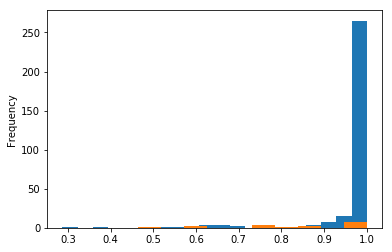

In [203]:
data= pd.Series(x4,index=[x.id for x in aln])
data[~data.index.isin(outliers)].plot.hist(bins=20)
data[outliers].plot.hist()

In [224]:
s = [x for x in NCBIXML.parse(StringIO(output))]
s[0]

In [339]:
d = s[0]
#for x in NCBIXML.parse(StringIO(output)):
    #print(x.alignments[0].hsps)
d2 = s[4].alignments[0]
d = s[4]
d3 = d2.hsps[0]
c = 

c

417

In [319]:
f = [x for x in NCBIXML.parse(StringIO(output)) if x.query == 'gi|976902695|gb|KVH90633.1| Ribulose bisphosphate carboxylase, large subunit, C-terminal [Cynara cardunculus var. scolymus]'][0]


[]

In [31]:
from Bio.Blast.Applications import NcbiblastpCommandline
output = NcbiblastpCommandline(query="../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa", subject="../data/Rr.faa", outfmt=5)()[0]
from Bio.Blast import NCBIXML
from io import StringIO

res = []
for x in NCBIXML.parse(StringIO(output)):
    if len(x.alignments) == 0:
        res.append(0)
    else:
        alignment = x.alignments[0]
        res.append(pd.DataFrame([[x.align_length,x.expect] for x in alignment.hsps]).sort_values(by=1).loc[0,0]/x.query_length)

ApplicationError: Non-zero return code 127 from 'blastp -outfmt 5 -query ../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa -subject ../data/Rr.faa', message '/bin/sh: 1: blastp: not found'

In [355]:
res_df = pd.Series(res,index=[x.id for x in aln])
res_df[outliers]
res_df[res_df < np.percentile(res_df,5)]

gi|1142664385|gb|ONM23707.1|        0.305732
gi|1271174125|gb|PHT97483.1|        0.353604
gi|33384245|gb|AAO49753.1|          0.359477
gi|1271204734|gb|PHU19935.1|        0.320628
gi|734330786|gb|KHN06855.1|         0.211246
gi|1270991417|gb|PHT34511.1|        0.354212
gi|976902695|gb|KVH90633.1|         0.000000
gi|1102146264|gb|OIT02594.1|        0.298148
gi|1129191087|gb|OLP96165.1|        0.086614
gi|1142664386|gb|ONM23708.1|        0.203673
gi|1270975270|gb|PHT27478.1|        0.186613
gi|1270991054|gb|PHT34148.1|        0.280347
gi|1271055537|gb|PHT66054.1|        0.121311
gi|1271096588|gb|PHT89599.1|        0.319196
gi|1271194407|gb|PHU11611.1|        0.291339
gi|1271198659|gb|PHU15862.1|        0.069264
gi|922401683|ref|XP_013467978.1|    0.049383
dtype: float64

5.214285714285714

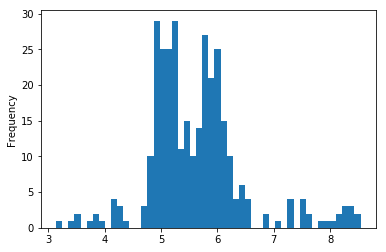

In [164]:
aln = AlignIO.read('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.aln',format='fasta')
seq = SeqIO.parse('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa',format='fasta')
#[y.id for x,y in zip(aln,seq)][-2]

#x4= [len(str(x.seq).replace('-',''))/len(y.seq) for x,y in zip(aln,seq)]
x4= [Counter(x.seq)['-']/len(y.seq) for x,y in zip(aln,seq)]
pd.Series(x4).plot.hist(bins=50)
seq = SeqIO.parse('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa',format='fasta')
f = [[z,x] for x,y,z in zip(aln,x4,seq) if y>np.percentile(x4,95)][-2]



In [166]:
%matplotlib inline
#pd.Series(x4).plot.hist(bins=50)
#[x.id for x,y in zip(aln,x3) if y > np.percentile(x3,95)]



In [ ]:
'gi|922401683|ref|XP_013467978.1|','gi|1271096588|gb|PHT89599.1|','gi|1142664386|gb|ONM23708.1|','gi|1271198659|gb|PHU15862.1|','gi|1271174125|gb|PHT97483.1|',''


In [124]:
cip = CipresClient.Client(appname='RO',
                    appID='rubisco_phylogeny-49F87B124F3D429FBE12F95E4254DDEA',
                    baseUrl='https://cipresrest.sdsc.edu/cipresrest/v1',
                    username='yinonbaron',
                    password='Mchcav11~')


In [125]:
job = cip.submitJob(vParams={'toolId': 'RAXMLHPC8_REST_XSEDE',
                       'datatype_': 'protein',
                       'runtime_': '160',
                       'select_analysis_': 'fa',
                       'choose_bootstrap_': 'x',
                       'printbrlength_': '1'},
              inputParams={'infile_': '../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8_trimmed_no_outliers.aln'},
              metadata={'statusEmail':'true'})

In [30]:
job = cip.listJobs()[-1]

In [165]:
if cip.getJobStatus(jobHandle=job.jobHandle).isDone():
    !mkdir -p ../output/02_80p_autotrophic_rubisco_tree/RaxML/
    job.downloadResults('../output/02_80p_autotrophic_rubisco_tree/RaxML/')
else:
    print('Job ' + job.jobHandle + ' not finished')

In [2]:
uclust1 = pd.read_csv('../output/00_100p_tree/uclust_all_1.csv')
uclust_data = pd.read_csv('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv')
uclust_data = uclust_data[uclust_data['Type'] !='S']
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data = uclust1.merge(uclust_data,left_on='Target',right_on='Query',suffixes=('_100', ''))
uclust_data.rename(columns={'Query':'Query_80','Query_100':'Query'},inplace=True)

In [3]:
add_type(type_file='../data/jaffe_et_al_2018_rubisco_types.csv',
         seq_file=uclust_data,
         outfile='../output/02_80p_autotrophic_rubisco_tree/type_legend.txt')

In [3]:
add_kinetic(kinetic_file='../data/flamholz_et_al_2019_kinetically_characterized.faa',
            synth_file='../data/milo_synthetized_rubisco.faa',
            seq_file='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv',
            outfile='../output/02_80p_autotrophic_rubisco_tree/kinetic_legend.txt')

In [29]:
uclust_data = pd.read_csv('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv')
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data.Target.nunique()


325

In [16]:
add_type(type_file='../data/jaffe_et_al_2018_rubisco_types.csv',
         seq_file='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv',
         outfile='../output/02_80p_autotrophic_rubisco_tree/type_legend.txt')

In [17]:
add_kinetic(kinetic_file='../data/flamholz_et_al_2019_kinetically_characterized.faa',
            synth_file='../data/milo_synthetized_rubisco.faa',
            seq_file='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv',
            outfile='../output/02_80p_autotrophic_rubisco_tree/kinetic_legend.txt')

In [18]:
type(uclust_data)

pandas.core.frame.DataFrame

In [5]:
type_file='../output/01_70p_tree/rubisco_types_70p.csv'
seq_file='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv'
outfile='../output/02_80p_autotrophic_rubisco_tree/type_legend.txt'

labels = pd.read_csv(type_file)
uclust_data = pd.read_csv(seq_file)
uclust_data = uclust_data[uclust_data['Type'] !='S']
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data['cut Query'] = uclust_data.Query.apply(lambda x: x.split(' ')[0])
uclust_data = uclust_data.merge(labels, left_on='cut Query', right_on='ID',how='left')
labeled_leaves = uclust_data[~pd.isna(uclust_data['type'])]
color_map = {'I': '#28B463',
             'II': '#E74C3C',
             'II/III':'#AF7AC5',
             'IIIa':'#AED6F1',
             'IIIb':'#3498DB',
             'IIIc':'#1F618D',
             'IIIlike':'#5D6D7E',
             'IV':'#F4D03F',
             'IVlike':'#F8C471',
             'unknown':'#F442D4'}
lines = labeled_leaves['Target'].apply(lambda x: x.split(' ')[0]).values +[',label,node,'+color_map[x]+',1,normal\n' for x in labeled_leaves['type'].values]
lines = set(lines)
'''
with open('../data/itol_legend_template.txt','r') as file:
    with open(outfile, "w") as f1:
        for row in file:
            f1.write(row)
        for line in lines:
            f1.write(line)
        file.close()
        f1.close()
        '''

KeyError: 'III-like'

In [17]:

labels = pd.read_csv('../data/jaffe_et_al_2018_rubisco_types.csv')


,Type_100,Cluster_100,Size_100,%Id_100,Strand_100,Qlo_100,Tlo_100,Alignment_100,Query_100,Target_100,...,Tlo_80,Alignment_80,Query_80,Target_80,cut Query,ID_x,type_x,ID_y,Organism,type_y
0,H,31,428,100.0,.,0,428,=,gwf2_scaffold_583_77,gwf2_scaffold_583_77 ribulose bisphosphate car...,...,*,*,gwf2_scaffold_583_77 ribulose bisphosphate car...,gwf2_scaffold_583_77 ribulose bisphosphate car...,gwf2_scaffold_583_77,gwf2_scaffold_583_77,II/III,gwf2_scaffold_583_77,Peregrinibacteria,II/III
1,H,46,451,100.0,.,0,0,8I451M2I,AAC38280_Riftia_pachyptila_endosymbiont_I_REF,"gi|2978568|gb|AAC38280.1| ribulose-1,5-bisphos...",...,*,*,"gi|2978568|gb|AAC38280.1| ribulose-1,5-bisphos...","gi|2978568|gb|AAC38280.1| ribulose-1,5-bisphos...",gi|2978568|gb|AAC38280.1|,NaN,NaN,AAC38280_Riftia_pachyptila_endosymbiont_I_REF,reference,II
2,H,48,454,100.0,.,0,0,9I454M,Desulfovibrio_aespoeensis_YP_00412229_REF,gi|503280792|ref|WP_013515453.1| ribulose-bisp...,...,*,*,gi|503280792|ref|WP_013515453.1| ribulose-bisp...,gi|503280792|ref|WP_013515453.1| ribulose-bisp...,gi|503280792|ref|WP_013515453.1|,gi|503280792|ref|WP_013515453.1|,II,Desulfovibrio_aespoeensis_YP_00412229_REF,reference,II
3,H,128,403,100.0,.,0,403,=,RBG_16_scaffold_32845_14,gi|1572540269|emb|VDD89222.1| RuBisCO long cha...,...,*,*,gi|1572540269|emb|VDD89222.1| RuBisCO long cha...,gi|1572540269|emb|VDD89222.1| RuBisCO long cha...,gi|1572540269|emb|VDD89222.1|,gi|1572540269|emb|VDD89222.1|,unknown,RBG_16_scaffold_32845_14,Micrarchaeota,unknown
4,H,133,418,100.0,.,0,418,=,rifcsphigho2_01_scaffold_71747_2,gi|1572540301|emb|VDD89247.1| RuBisCO long cha...,...,*,*,gi|1572540301|emb|VDD89247.1| RuBisCO long cha...,gi|1572540301|emb|VDD89247.1| RuBisCO long cha...,gi|1572540301|emb|VDD89247.1|,gi|1572540301|emb|VDD89247.1|,IIIc,rifcsphigho2_01_scaffold_71747_2,Kuenenbacteria,IIIc
5,H,362,461,100.0,.,0,0,16I461M6I,Chondrophycus_papillosus_ABO3124_REF,"gi|166078534|gb|ABY81245.1| ribulose-1,5-bisph...",...,0,22D447M14D,"gi|166078534|gb|ABY81245.1| ribulose-1,5-bisph...","gi|1102130949|gb|APC24827.1| ribulose-1,5-bisp...",gi|166078534|gb|ABY81245.1|,NaN,NaN,Chondrophycus_papillosus_ABO3124_REF,reference,I
6,H,407,423,100.0,.,0,0,45D378M,UBA1558contig_16814_5,gi|1278699910|gb|PJC01515.1| ribulose-bisphosp...,...,*,*,gi|1278699910|gb|PJC01515.1| ribulose-bisphosp...,gi|1278699910|gb|PJC01515.1| ribulose-bisphosp...,gi|1278699910|gb|PJC01515.1|,gi|1278699910|gb|PJC01515.1|,IIIc,UBA1558contig_16814_5,Patescibacteria,IIIc
7,H,448,476,100.0,.,0,476,=,emb_CDO21134_Mycobacterium_mageritense_DSM_444...,gi|738479616|ref|WP_036429835.1| form I ribulo...,...,0,476M,gi|738479616|ref|WP_036429835.1| form I ribulo...,gi|1278930891|gb|PJE17214.1| ribulose-bisphosp...,gi|738479616|ref|WP_036429835.1|,NaN,NaN,emb_CDO21134_Mycobacterium_mageritense_DSM_444...,reference,I
8,H,703,465,100.0,.,0,465,=,rifoxyd1_full_scaffold_17021_2,gi|1572539530|emb|VDD88826.1| RuBisCO long cha...,...,*,*,gi|1572539530|emb|VDD88826.1| RuBisCO long cha...,gi|1572539530|emb|VDD88826.1| RuBisCO long cha...,gi|1572539530|emb|VDD88826.1|,gi|1572539530|emb|VDD88826.1|,III-like,rifoxyd1_full_scaffold_17021_2,Pacearchaeota,IIIlike
9,H,717,461,100.0,.,0,0,26I461M6I,Galdieria_Partita_1IW_REF,"gi|30749269|pdb|1IWA|A Chain A, Rubisco From G...",...,0,32D447M14D,"gi|30749269|pdb|1IWA|A Chain A, Rubisco From G...","gi|1102130949|gb|APC24827.1| ribulose-1,5-bisp...",gi|30749269|pdb|1IWA|A,NaN,NaN,Galdieria_Partita_1IW_REF,reference,I
